# Bandgap prediction using Element Fraction Data
This notebook uses Element Fraction data in order to predict bandgaps of certain compositions
Following the Ward 2016 paper, this notebook provides machine learning techniques trained on composition attributes 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
import matminer
import sys

sys.path.append("/Users/Ashwin/Desktop/git/matminer")

%matplotlib inline

In [2]:
training_file = "data/oqmd_all.csv"

# Load training data from oqmd database

In [3]:
training_set = pd.read_csv(training_file, delim_whitespace=True, na_values=['None'])
training_set.head()
training_set.shape

(347329, 7)

In [4]:
min_value = min(np.array(training_set['energy_pa'], dtype=float))
#Replace outlier values
training_set = training_set.replace(str(min_value), np.nan)

In [5]:
training_set['is_groundstate'] = False
training_set.shape

(347329, 8)

# Get all groundstate values for each compound
Sort by energy_pa : for repeated compounds, only keep lowest energy state

In [6]:
%%time
for gid, group in training_set.groupby('comp'):
    group = group.sort_values('energy_pa', ascending=True)
    training_set.loc[group.iloc[0].name, 'is_groundstate'] = True
training_set.shape

CPU times: user 5min 29s, sys: 2.26 s, total: 5min 31s
Wall time: 5min 34s


In [19]:
original_count = len(training_set)
training_set = training_set[training_set['is_groundstate']]
removed = original_count - len(training_set)
print("Removed", removed, "/", original_count)

Removed 0 / 228676


# Compute descriptors using MatMiner

In [20]:
from pymatgen import Composition
from matminer.descriptors.composition_features import ElementFractionAttribute

In [21]:
def calc_attributes(training_set):
    training_set_updated = ElementFractionAttribute().featurize_all(training_set, col_id="comp")
    return training_set_updated
training_set_bg = calc_attributes(training_set)
training_set_bg.replace(np.inf, np.nan, inplace=True)
training_set_bg.dropna(inplace=True)

In [22]:
bandgaps = np.array(training_set_bg["bandgap"], dtype=float)
#Round to integer values
bg_range = np.zeros(np.shape(bandgaps), dtype=str)
for i in range(len(bandgaps)):
    if bandgaps[i] == 0:
        bg_range[i] = "0"
    elif bandgaps[i] > 0 and bandgaps[i] < 1.5:
        bg_range[i] = "1"
    elif bandgaps[i] >= 1.5 and bandgaps[i] < 3.0:
        bg_range[i] = "2"
    elif bandgaps[i] >= 3.0:
        bg_range[i] = "3"

In [23]:
#drop default columns
cols_to_drop = ['comp', 'energy_pa', 'volume_pa', 'magmom_pa', 'bandgap', 'delta_e', 'stability', 'is_groundstate']

# Predict Bandgaps 
### Random Forest Classifier

In [24]:
from pymatgen import Element
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_bg.drop(cols_to_drop, axis=1), bg_range)
prediction = model1.predict(training_set_bg.drop(cols_to_drop, axis=1))

In [25]:
pd.crosstab(bg_range, prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,113885,2,3,2
1,174,1880,9,0
2,46,8,1700,1
3,25,1,8,1074


### Predict Bandgaps with DecisionTreeClassifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier()
model2.fit(training_set_bg.drop(cols_to_drop, axis=1), bg_range)
prediction = model2.predict(training_set_bg.drop(cols_to_drop, axis=1))

In [27]:
pd.crosstab(bg_range, prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,113892,0,0,0
1,0,2063,0,0
2,0,0,1755,0
3,0,0,0,1108


### Predict Bandgaps using RandomForestRegressor

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(training_set_bg.drop(cols_to_drop, axis=1), bandgaps)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [29]:
prediction = rf_model.predict(training_set_bg.drop(cols_to_drop, axis=1))

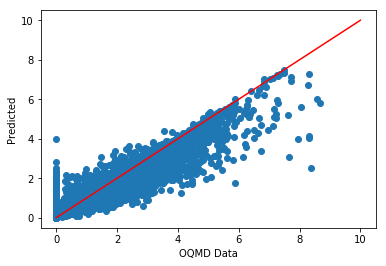

In [30]:
plt.scatter(bandgaps, prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

# Predict Volume